前面2个例子都是分类问题，目标是预测数据数据点所一应的单一离散的标签。还有一类是`回归`问题，与侧一个连续值而不是离散的标签。

In [1]:
# 加载数据
from keras.datasets import boston_housing

(train_data,train_targets),(test_data,test_targets) = boston_housing.load_data()

65536/57026 [==================================] - 0s 3us/step


In [3]:
print("train_data.shape", train_data.shape)
print("test_data.shape", test_data.shape)

train_data.shape (404, 13)
test_data.shape (102, 13)


我们有404个训练样本和102个测试样本，每个样本有13个数值特征。

In [4]:
# 数据标准化
'''
数值波动不能太大，学习会变困难
对特征做标准化
对输入数据的每个特征，减去特征平均值，在除以标准差
'''
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [5]:
# 构建网络
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

网络的最优一层只有1个单元，没有激活，是一个线性层。这是标量回归的典型设置。添加激活函数会限制输出范围。如果最后一层添加sigmoid激活函数，只会预测0-1范围的值。

- MSE: 均方误差 mean sequred error
- MAE: 平均绝对误差 mean abosolute error

数据会被划分为训练集和验证集。但是本例中数据点很少，验证集会非常小，因此验证分数会有很大的波动。这种情况下，使用`K折`交叉验证。
![img](images/003-008.png)
![img](images/003-009.png)

In [6]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    # 分割数据
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] # 准备验证数据集
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
         axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
          train_targets[(i + 1) * num_val_samples:]],
          axis=0)

    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0


2021-12-13 11:17:10.600997: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


processing fold # 1
processing fold # 2
processing fold # 3


In [7]:
print("all_scores: ", all_scores)
print("np.mean(all_scores): ", np.mean(all_scores))

all_scores [2.041398286819458, 2.400531053543091, 2.9826605319976807, 2.3203766345977783]
np.mean(all_scores) 2.436241626739502


从上面数据看，我们预测的最高误差有2980美元，相对比10000-50000美元，差别还是非常大的。所以我们需要训练时间再长一点,并且记录下来。

In [16]:
from keras import backend as K

K.clear_session()

In [17]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    # 分割数据
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] # 准备验证数据集
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
         axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
          train_targets[(i + 1) * num_val_samples:]],
          axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
              validation_data=(val_data, val_targets),
              epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae'] # 注意这个地方，key变了，按照书上的代码会错误
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [18]:
average_mae_history = [ np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

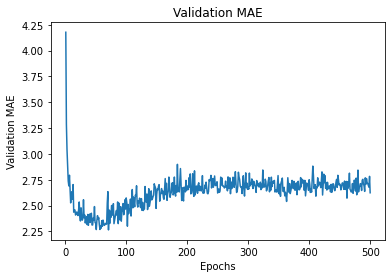

In [20]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

上图展示了每轮验证的MAE，由于纵轴范围较大，且数据方差相对较大，很难看清这张图的规律。我们重新会议新的图：
- 删除前10个点
- 将每个数据点替换为前面数据点的直属移动平均值，已得到光滑的曲线

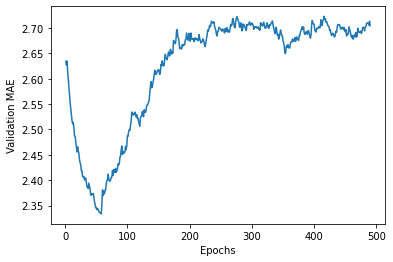

In [24]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [25]:
np.argmin(smooth_mae_history)

57

从这个图上可以清晰看出，验证MAE在80轮后不再显著降低，开始过拟合了，所以epoch可以设置为80.从代码显示看，epoch为67就差不多了（57+10）

In [26]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=67, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mse_score)

4/4 [==============================] - 0s 955us/step - loss: 17.0276 - mae: 2.5871
17.0275936126709


实际结果比刚才好一点点